In [1]:
#For accessing files
import os
import glob

#For Images
import cv2
import matplotlib.pyplot as plt
import numpy as np

#For checking progress
from tqdm import tqdm_notebook

import datetime

#PyTorch Packages
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

/home/catalin/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
torch.multiprocessing.set_start_method('spawn')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Add this line if you don't want to use GPU
# device = torch.device('cpu') 
torch.set_default_device(device)

In [3]:
def get_image(path,transform=False):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if transform:
        img = transform(img)
    return img

def show_data(rows,cols,is_train=True,transform=False):
    if is_train:
        path = './dataset/train/'
    else:
        path = './dataset/test/'
    path = os.path.join(path,'*','*.png')
    img_paths = glob.glob(path)
    np.random.seed(0)
    img_paths = np.random.choice(img_paths,rows*cols)
    fig = plt.figure(figsize=(8,8),dpi=150)
    i = 1
    for r in range(rows):
        for c in range(cols):
            image_path = img_paths[i-1]
            if 'fresh' in image_path.split('/')[-2]:
                title = 'Fresh'
            else:
                title = 'Rotten'
            ax = fig.add_subplot(rows,cols,i)
            img = get_image(image_path,transform)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(title,fontsize=5)
            ax.imshow(img)
            i+=1
    return fig

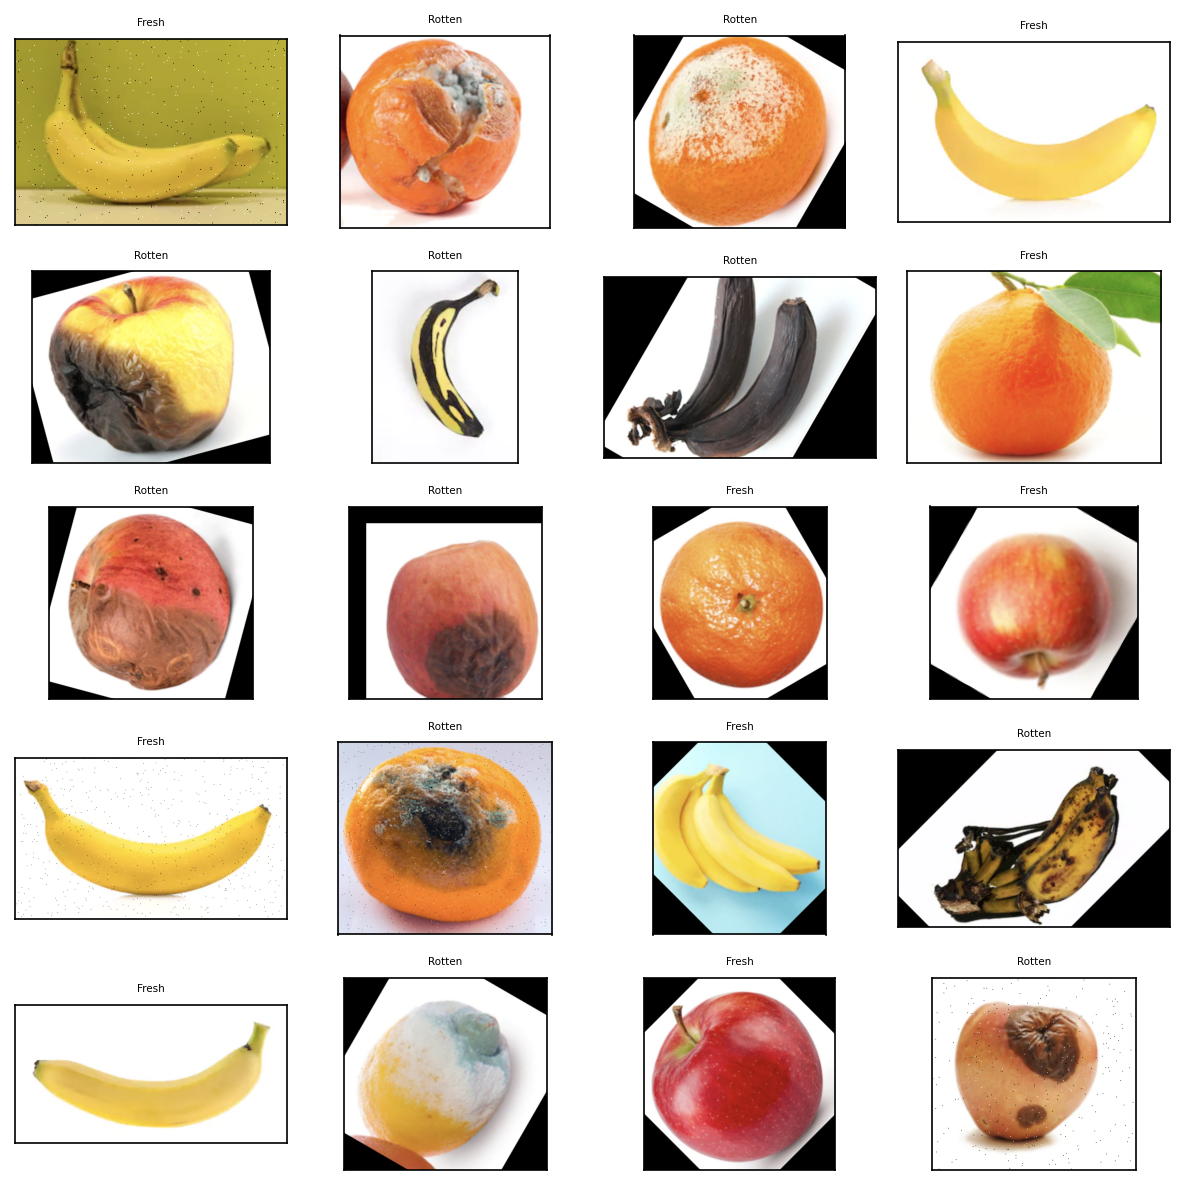

In [4]:
fig = show_data(5,4)
fig.tight_layout()

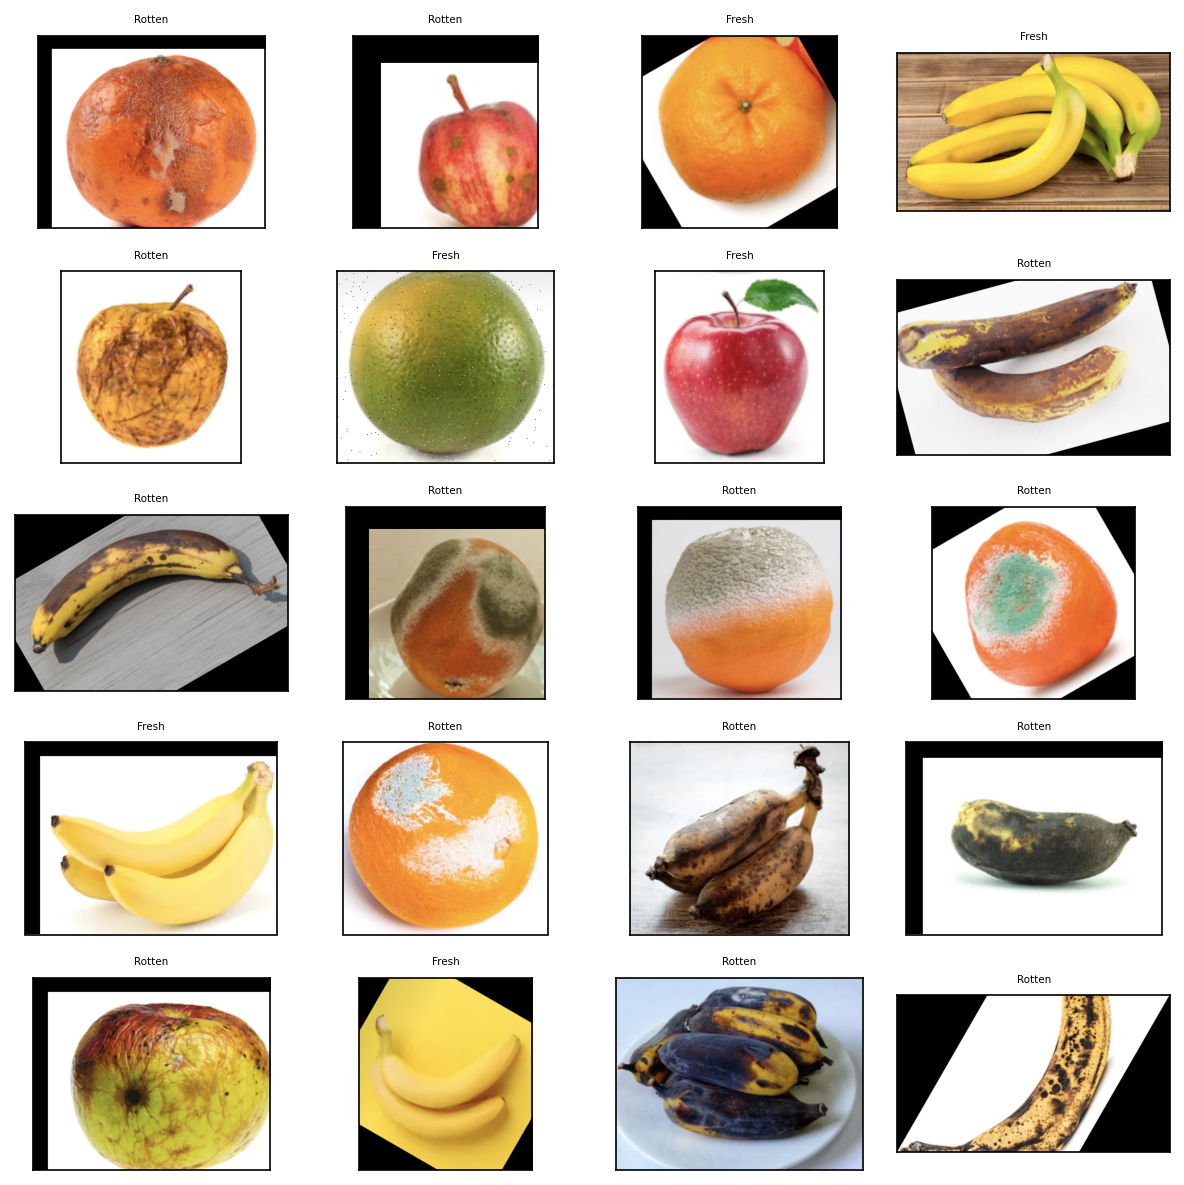

In [13]:
fig = show_data(5,4,is_train=False)
fig.tight_layout()

In [6]:
class FruitsDataset(Dataset):
    def __init__(self,path,classifier_type='Rotten',subset='train',transforms=None):
        self.subset = subset
        if self.subset == 'train':
            self.PATH = os.path.join(path,'train','*','*.png')
        elif self.subset == 'test':
            self.PATH = os.path.join(path,'test','*','*.png')
        self.data = glob.glob(self.PATH)
        self.height = 32
        self.width = 32
        self.labels = [] 
        if classifier_type == 'Rotten':
            classes = ['fresh','rotten']
            for fruit in self.data:
                if classes[0] in fruit.split('/')[-2]:
                    self.labels.append(0)
                else:
                    self.labels.append(1)
        else:
            classes = ['apple','banana','orange']
            for fruit in self.data:
                if classes[0] in fruit:
                    self.labels.append(0)
                elif classes[1] in fruit:
                    self.labels.append(1)
                else:
                    self.labels.append(2)
        self.transforms = transforms

    def __getitem__(self,index):
        img_path = self.data[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(self.width,self.height))
        label = self.labels[index]
        if self.transforms is not None:
            img_as_tensor = self.transforms(img)
            if self.transforms is not None:
                return(img_as_tensor,label)
            return(img,label)

    def __len__(self):
        return(len(self.data))

In [21]:
class RamDataset(torch.utils.data.Dataset):
    def __init__(self, dataset: Dataset):
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))
        self._images, self._labels = next(iter(data_loader))
    def __getitem__(self, index):
        return self._images[index], self._labels[index]
    def __len__(self):
        return self._images.shape[0]

In [39]:
transformations = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.7321, 0.6322, 0.5291),(0.3302, 0.3432, 0.3701))])
dataset = RamDataset(FruitsDataset('./dataset',transforms = transformations))


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


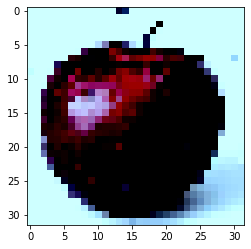

In [23]:
img_t, _ = dataset[1000]
img = img_t.permute(1,2,0)
plt.imshow(img)

In [24]:
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [25]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(16,8,kernel_size=3,padding=1)
        self.fc1 = nn.Linear(8*8*8,32)
        self.fc2 = nn.Linear(32,2)
    def forward(self,x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = out.view(-1,8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [26]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [30]:
def training_loop(n_epochs,optimizer,model,loss_fn,train_loader):
    losss=[]
    train_loss=[]
    acc=[]
    for epoch in tqdm_notebook(range(1,n_epochs+1)):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs,labels)
            losss.append(loss)
            #get rid of gradients from last round
            optimizer.zero_grad()
            #performs backward step. Computes all the gradients
            loss.backward()
            #Updates the model
            optimizer.step()
            loss_train += loss.item()
        train_loss.append(loss_train) # append loss in train_loss
        print(train_loss)
        acc.append((loss_train/len(train_loader)))#append accoracy in acc list 
        print(loss_train/len(train_loader))
        print('{} Epoch {}, Training Loop {}'.format(
          datetime.datetime.now(), epoch, loss_train/len(train_loader)))
    return acc

model = Net().to(device=device) #was talking about this above
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
acc_=training_loop(
  n_epochs = 5,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = train_loader,
)

  0%|          | 0/5 [00:00<?, ?it/s]

[80.03030532598495]
0.5841628125984303
2024-03-31 20:19:27.671308 Epoch 1, Training Loop 0.5841628125984303
[80.03030532598495, 65.77380836009979]
0.48010079094963354
2024-03-31 20:19:28.173479 Epoch 2, Training Loop 0.48010079094963354
[80.03030532598495, 65.77380836009979, 60.64925962686539]
0.442695325743543
2024-03-31 20:19:28.648967 Epoch 3, Training Loop 0.442695325743543
[80.03030532598495, 65.77380836009979, 60.64925962686539, 54.762344390153885]
0.39972514153397
2024-03-31 20:19:29.157190 Epoch 4, Training Loop 0.39972514153397
[80.03030532598495, 65.77380836009979, 60.64925962686539, 54.762344390153885, 48.487533539533615]
0.35392360247834753
2024-03-31 20:19:29.706159 Epoch 5, Training Loop 0.35392360247834753


In [31]:
print("acc")
print(acc_)

acc
[0.5841628125984303, 0.48010079094963354, 0.442695325743543, 0.39972514153397, 0.35392360247834753]


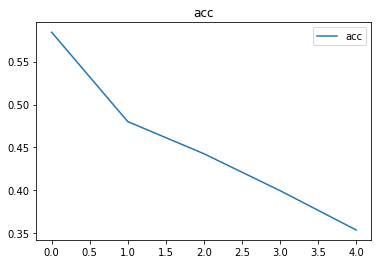

In [32]:
plt.plot(acc_,label="acc")
plt.title("acc")
plt.legend()
plt.show()

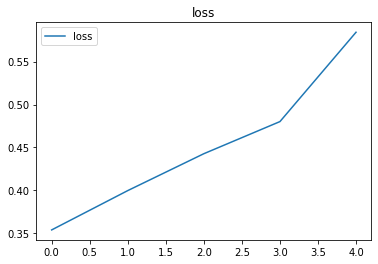

In [33]:
loss=acc_[::-1]
plt.plot(loss,label="loss")
plt.title("loss")
plt.legend()
plt.show()

In [34]:
print("loss")
print(loss)

loss
[0.35392360247834753, 0.39972514153397, 0.442695325743543, 0.48010079094963354, 0.5841628125984303]


In [35]:
torch.save(model.state_dict(), 'FreshnessDetector.pt')

In [36]:
def validate(model,train_loader,val_loader):
    for name, loader in [('train',train_loader),('val',validation_loader)]:
        correct = 0
        total = 0

        #gradients nor required, as we don't want to train our parameters
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                #max_index,value
                _,predicted = torch.max(outputs,dim=1)
                total+=labels.shape[0]
                correct+=int((predicted==labels).sum())
    
        print('Accuracy {}: {:.2f}'.format(name, correct/total))

validate(model,train_loader,validation_loader)

Accuracy train: 0.84
Accuracy val: 0.85


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual: 0
Prediction: tensor([[ 0.3318, -0.6326]], device='cuda:0', grad_fn=<AddmmBackward0>)


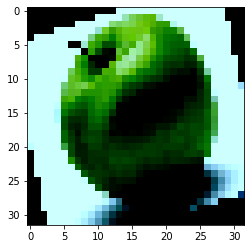

In [37]:
img,label = dataset[1]
plt.imshow(img.permute(1,2,0))
out = model(img.unsqueeze(0).to(device))
print('Actual: {}'.format(label))
print('Prediction: {}'.format(out))

In [38]:
transformations_test = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.7369, 0.6360, 0.5318),
                                                           (0.3281, 0.3417, 0.3704))
                                      ])